In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt

In [3]:
# Load the data
df = pd.read_csv('data_co2.csv', names=['Year', 'PPM'], skiprows=1)

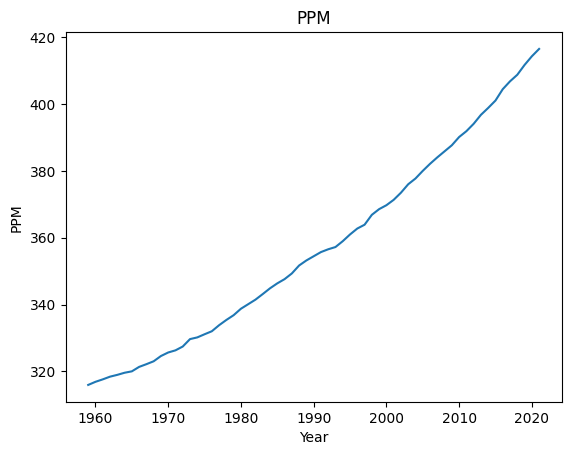

In [4]:
plt.plot(df['Year'], df['PPM'])
plt.xlabel('Year')
plt.ylabel('PPM')
plt.title('PPM')
plt.show()

In [5]:
df.drop('Year', axis=1, inplace=True)
data = df.values


def normalize(data, min, max):
    data = data - min
    data = data / (max - min)
    return data


def unnormalize(data, min, max):
    data = data * (max - min)
    data = data + min
    return data


data_normed = normalize(data, data.min(axis=0), data.max(axis=0))
data_normed[:10]

array([[0.        ],
       [0.00925649],
       [0.01652234],
       [0.02458445],
       [0.02995919],
       [0.03622972],
       [0.04041007],
       [0.05364786],
       [0.06170996],
       [0.07036926]])

In [6]:
split = int(0.8 * len(data_normed))
train, val = data_normed[:split], data_normed[split:]


def windowed_dataset(series, batch_size, n_past=10, n_future=10, shift=1):
    '''
    :param series: an iterable
    :param batch_size: number of samples per batch
    :param n_past: number of timesteps to look back (x or input to the model)
    :param n_future: number of timesteps to predict (y or output of the model)
    :param shift: number of timesteps to shift the window by, usually 1 if we want to maximise the use of data
    :return:
    '''
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_future], w[n_future:]))  # taking the past as x, future as y, split by n_past
    ds.shuffle(8192)
    return ds.batch(batch_size).prefetch(1)


batch_size = 32  # explore how changing this affects the model (it is not as simple as larger batch size = better performance, lik ein image tasks)
n_past = 5
n_future = 5
shift = 1

train_ds = windowed_dataset(train, batch_size, n_past, n_future, shift)
valid_ds = windowed_dataset(val, batch_size, n_past, n_future, shift)

In [7]:
print(train_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>


In [8]:
xIn = tf.keras.layers.Input(shape=(n_past,
                                   1))  # 20 input, where first dimension is the number of timesteps to look back, 2nd dimension is the number of features
x = tf.keras.layers.LSTM(32, return_sequences=True)(xIn)  # LSTM layer with 32 hidden units. Return
x = tf.keras.layers.LSTM(32)(x)
xOut = tf.keras.layers.Dense(n_future)(x)
model = tf.keras.Model(inputs=xIn, outputs=xOut)
model.compile(loss='mse', optimizer='adam', metrics='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 5, 32)             4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 12,837
Trainable params: 12,837
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.fit(train_ds, epochs=100, validation_data=valid_ds)

Epoch 1/100
2/2 [==============================] - 7s 3s/step - loss: 0.1316 - mse: 0.1316 - val_loss: 0.7752 - val_mse: 0.7752
Epoch 2/100
2/2 [==============================] - 0s 63ms/step - loss: 0.1244 - mse: 0.1244 - val_loss: 0.7454 - val_mse: 0.7454
Epoch 3/100
2/2 [==============================] - 0s 79ms/step - loss: 0.1173 - mse: 0.1173 - val_loss: 0.7146 - val_mse: 0.7146
Epoch 4/100
2/2 [==============================] - 0s 63ms/step - loss: 0.1102 - mse: 0.1102 - val_loss: 0.6822 - val_mse: 0.6822
Epoch 5/100
2/2 [==============================] - 0s 76ms/step - loss: 0.1028 - mse: 0.1028 - val_loss: 0.6478 - val_mse: 0.6478
Epoch 6/100
2/2 [==============================] - 0s 62ms/step - loss: 0.0951 - mse: 0.0951 - val_loss: 0.6109 - val_mse: 0.6109
Epoch 7/100
2/2 [==============================] - 0s 62ms/step - loss: 0.0870 - mse: 0.0870 - val_loss: 0.5712 - val_mse: 0.5712
Epoch 8/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0786 - mse: 0.0786

In [10]:
preds = model.predict(windowed_dataset(data_normed, batch_size, n_past, n_future, shift))
preds[0]

2/2 [==============================] - 1s 16ms/step


array([0.08276229, 0.10092065, 0.10197784, 0.10337434, 0.11530215],
      dtype=float32)

In [11]:
new_forecast = []

new_forecast_series = data_normed[-n_past:]

pred = model.predict(new_forecast_series[np.newaxis])

1/1 [==============================] - 1s 927ms/step


In [12]:
new_forecast_series.shape

(5, 1)

In [13]:
new_data_normed = np.concatenate((data_normed, pred[:, 0]), axis=None)

In [14]:
data_normed

array([[0.        ],
       [0.00925649],
       [0.01652234],
       [0.02458445],
       [0.02995919],
       [0.03622972],
       [0.04041007],
       [0.05364786],
       [0.06170996],
       [0.07036926],
       [0.08599582],
       [0.09654623],
       [0.10291629],
       [0.11426296],
       [0.13635911],
       [0.14143525],
       [0.15079128],
       [0.15974918],
       [0.17776451],
       [0.19339106],
       [0.20762417],
       [0.22673435],
       [0.24027073],
       [0.25380711],
       [0.27042898],
       [0.28754852],
       [0.30227929],
       [0.31482034],
       [0.33174082],
       [0.35542948],
       [0.37045884],
       [0.38290037],
       [0.39534189],
       [0.4037026 ],
       [0.41037126],
       [0.42778939],
       [0.44779536],
       [0.46541256],
       [0.47675923],
       [0.50622076],
       [0.52314124],
       [0.5347865 ],
       [0.55081119],
       [0.57201155],
       [0.59719319],
       [0.61431273],
       [0.63700607],
       [0.658

In [15]:
new_data_normed

array([0.        , 0.00925649, 0.01652234, 0.02458445, 0.02995919,
       0.03622972, 0.04041007, 0.05364786, 0.06170996, 0.07036926,
       0.08599582, 0.09654623, 0.10291629, 0.11426296, 0.13635911,
       0.14143525, 0.15079128, 0.15974918, 0.17776451, 0.19339106,
       0.20762417, 0.22673435, 0.24027073, 0.25380711, 0.27042898,
       0.28754852, 0.30227929, 0.31482034, 0.33174082, 0.35542948,
       0.37045884, 0.38290037, 0.39534189, 0.4037026 , 0.41037126,
       0.42778939, 0.44779536, 0.46541256, 0.47675923, 0.50622076,
       0.52314124, 0.5347865 , 0.55081119, 0.57201155, 0.59719319,
       0.61431273, 0.63700607, 0.65800737, 0.67721708, 0.69523241,
       0.71324774, 0.73773266, 0.75515079, 0.77714741, 0.80382204,
       0.8244252 , 0.84632229, 0.88016323, 0.9035533 , 0.92306161,
       0.95232408, 0.97800338, 1.        , 1.13432074])

In [16]:
new_forecast_series = new_data_normed[-n_past:]

new_forecast_series = new_forecast_series.reshape(5,1)

pred = model.predict(new_forecast_series[np.newaxis])

1/1 [==============================] - 0s 41ms/step


In [17]:
pred

array([[1.1704571, 1.2189816, 1.2995629, 1.246846 , 1.3139842]],
      dtype=float32)

In [18]:
pred[:,0]

array([1.1704571], dtype=float32)

In [19]:
unnormalize(pred, data.min(axis=0), data.max(axis=0))

array([[433.57582732, 438.45108373, 446.54708768, 441.25061366,
        447.99598812]])

In [20]:
preds_unnormed = unnormalize(preds, data.min(axis=0), data.max(axis=0))

In [21]:
preds_unnormed[:, 0]

array([324.29512688, 324.85098196, 325.3406389 , 325.83756735,
       326.32358929, 326.8834806 , 327.54350976, 328.39455492,
       329.17347484, 330.0308633 , 331.02179483, 331.90697431,
       332.81896123, 333.88971319, 335.01408898, 335.84199765,
       336.92848584, 338.21412088, 339.74898294, 341.22965974,
       342.73383682, 344.32394558, 345.81122917, 347.37559347,
       349.03945034, 350.74216646, 352.45664993, 354.25879875,
       356.22864892, 358.13293722, 359.57296872, 360.88329277,
       362.21897203, 363.63051933, 365.31926732, 367.53222577,
       369.83821523, 372.07110334, 374.31398622, 376.89704463,
       379.00428247, 381.18831058, 383.77759102, 386.62254956,
       389.47424513, 392.09276132, 394.83903571, 397.46573816,
       400.02054891, 402.60802083, 405.34928286, 408.2664385 ,
       411.05015885, 414.14030965])

In [22]:
print(preds_unnormed.shape)
print(preds_unnormed[:, 0])
print(preds_unnormed[:, 0].shape)

(54, 5)
[324.29512688 324.85098196 325.3406389  325.83756735 326.32358929
 326.8834806  327.54350976 328.39455492 329.17347484 330.0308633
 331.02179483 331.90697431 332.81896123 333.88971319 335.01408898
 335.84199765 336.92848584 338.21412088 339.74898294 341.22965974
 342.73383682 344.32394558 345.81122917 347.37559347 349.03945034
 350.74216646 352.45664993 354.25879875 356.22864892 358.13293722
 359.57296872 360.88329277 362.21897203 363.63051933 365.31926732
 367.53222577 369.83821523 372.07110334 374.31398622 376.89704463
 379.00428247 381.18831058 383.77759102 386.62254956 389.47424513
 392.09276132 394.83903571 397.46573816 400.02054891 402.60802083
 405.34928286 408.2664385  411.05015885 414.14030965]
(54,)


In [23]:
pred[0][0]

1.1704571

1/1 [==============================] - 0s 31ms/step
0 [429.94520434]
1/1 [==============================] - 0s 31ms/step
1 [433.57582732]
1/1 [==============================] - 0s 23ms/step
2 [438.25690132]
1/1 [==============================] - 0s 31ms/step
3 [443.76206184]
1/1 [==============================] - 0s 23ms/step
4 [450.36124556]
1/1 [==============================] - 0s 32ms/step
5 [458.19934969]
1/1 [==============================] - 0s 32ms/step
6 [462.82050297]
1/1 [==============================] - 0s 32ms/step
7 [467.90330808]
1/1 [==============================] - 0s 32ms/step
8 [473.09389382]
1/1 [==============================] - 0s 32ms/step
9 [478.08277562]
1/1 [==============================] - 0s 47ms/step
10 [482.46677317]
1/1 [==============================] - 0s 47ms/step
11 [485.82819008]
1/1 [==============================] - 0s 44ms/step
12 [489.02785818]
1/1 [==============================] - 0s 32ms/step
13 [491.89624364]
1/1 [=========================

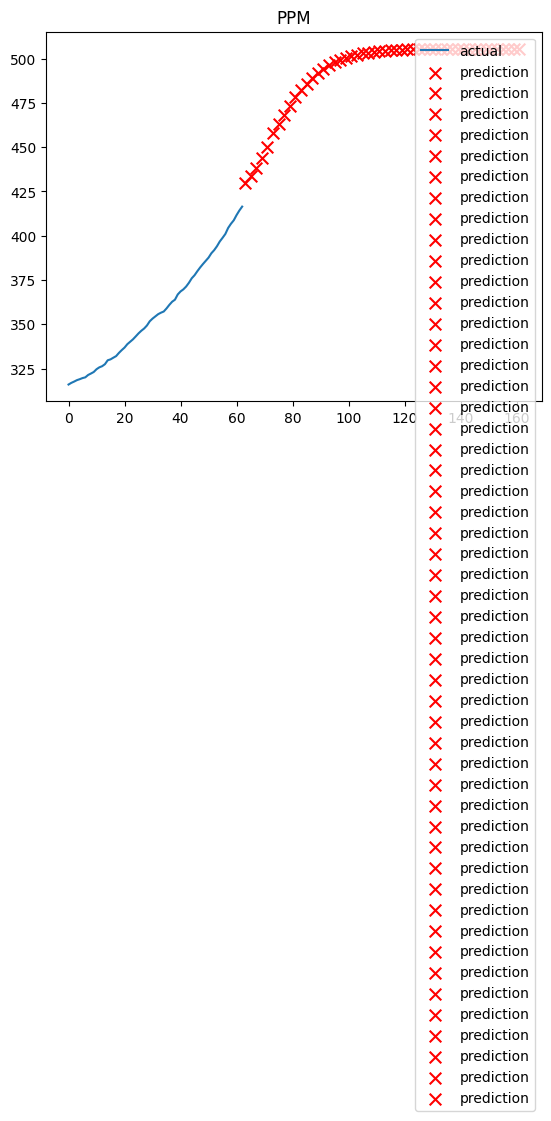

In [24]:
plt.plot(unnormalize(data_normed, data.min(axis=0), data.max(axis=0)),
         label='actual')  # our val was taken as subset of the normaized data so we need to unnormalize it here
# plt.plot(unnormalize(pred[0][0], data.min(axis=0), data.max(axis=0)), label='prediction')

for i in range(50):
    new_forecast_series = data_normed[-n_past:]
    pred = model.predict(new_forecast_series.reshape(5,1)[np.newaxis])

    print(i, unnormalize(pred[:,0], data.min(axis=0), data.max(axis=0)))

    plt.scatter(len(data_normed)+i, unnormalize(pred[:,0], data.min(axis=0), data.max(axis=0)), color="red", marker="x", s=70, label="prediction")

    data_normed = np.concatenate((data_normed, pred[:, 0]), axis=None)


plt.legend()
plt.title('PPM')
plt.show()

In [25]:
train = train + preds[:, 0]

train_ds = windowed_dataset(train, batch_size, n_past, n_future, shift)

In [26]:
np.add(train, preds[:, 0])

array([[0.16552457, 0.17658967, 0.18633699, ..., 1.83709443, 1.89250839,
        1.95402229],
       [0.17478107, 0.18584616, 0.19559349, ..., 1.84635092, 1.90176488,
        1.96327878],
       [0.18204692, 0.19311201, 0.20285934, ..., 1.85361677, 1.90903073,
        1.97054463],
       ...,
       [0.82353194, 0.83459703, 0.84434436, ..., 2.49510179, 2.55051575,
        2.61202965],
       [0.84274165, 0.85380675, 0.86355407, ..., 2.51431151, 2.56972547,
        2.63123937],
       [0.86075698, 0.87182208, 0.8815694 , ..., 2.53232683, 2.5877408 ,
        2.6492547 ]])

In [27]:
np.concatenate((train, preds[:, 0].reshape(41,1)), axis=None)

ValueError: cannot reshape array of size 54 into shape (41,1)

In [ ]:
train

In [ ]:
preds[:, 0].reshape(41,1)